In [ ]:
#Data Preprocessing

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import StandardScaler
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [ ]:
train = pd.read_csv('/content/UNSW_NB15_training-set.csv')
test = pd.read_csv('/content/UNSW_NB15_testing-set.csv')
if train.shape[0]<100000:
    print("Train test sets are reversed. Fixing. ")
    train, test = test, train

# https://www.kaggle.com/khairulislam/unsw-nb15-feature-importance
drop_columns = ['attack_cat', 'id'] + ['response_body_len', 'spkts', 'ct_flw_http_mthd', 'trans_depth', 'dwin', 'ct_ftp_cmd', 'is_ftp_login']
for df in [train, test]:
    for col in drop_columns:
        if col in df.columns:
            print('Dropping '+col)
            df.drop([col], axis=1, inplace=True)

Train test sets are reversed. Fixing. 
Dropping attack_cat
Dropping id
Dropping response_body_len
Dropping spkts
Dropping ct_flw_http_mthd
Dropping trans_depth
Dropping dwin
Dropping ct_ftp_cmd
Dropping is_ftp_login
Dropping attack_cat
Dropping id
Dropping response_body_len
Dropping spkts
Dropping ct_flw_http_mthd
Dropping trans_depth
Dropping dwin
Dropping ct_ftp_cmd
Dropping is_ftp_login


In [ ]:
def feature_engineer(df):
    df.loc[~df['state'].isin(['FIN', 'INT', 'CON', 'REQ', 'RST']), 'state'] = 'others'
    df.loc[~df['service'].isin(['-', 'dns', 'http', 'smtp', 'ftp-data', 'ftp', 'ssh', 'pop3']), 'service'] = 'others'
    df.loc[df['proto'].isin(['igmp', 'icmp', 'rtp']), 'proto'] = 'igmp_icmp_rtp'
    df.loc[~df['proto'].isin(['tcp', 'udp', 'arp', 'ospf', 'igmp_icmp_rtp']), 'proto'] = 'others'
    return df

def get_cat_columns(train):
    categorical = []
    for col in train.columns:
        if train[col].dtype == 'object':
            categorical.append(col)
    return categorical

In [ ]:
x_train, y_train = train.drop(['label'], axis=1), train['label']
x_test, y_test = test.drop(['label'], axis=1), test['label']

x_train, x_test = feature_engineer(x_train), feature_engineer(x_test)

categorical_columns = get_cat_columns(x_train)
non_categorical_columns = [x for x in x_train.columns if x not in categorical_columns]

scaler = StandardScaler()
x_train[non_categorical_columns] = scaler.fit_transform(x_train[non_categorical_columns])
x_test[non_categorical_columns] = scaler.transform(x_test[non_categorical_columns])


x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)
print("Column mismatch {0}, {1}".format(set(x_train.columns)- set(x_test.columns),  set(x_test.columns)- set(x_train.columns)))
features = list(set(x_train.columns) & set(x_test.columns))

print(f"Number of features {len(features)}")
x_train = x_train[features]
x_test = x_test[features]

Column mismatch set(), set()
Number of features 53


In [ ]:
x_train['label'] = y_train
x_test['label'] = y_test
x_train.to_csv('train.csv', index=False)
x_test.to_csv('test.csv', index=False)

In [ ]:
#Now the Binary Classification

In [ ]:
# helper module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
import joblib

# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
# from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# processing & metrics imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import recall_score

In [ ]:
# fetch the training file
file_path_full_training_set = r'/content/UNSW_NB15_training-set.csv'
file_path_test = r'/content/UNSW_NB15_testing-set.csv'

#df = pd.read_csv(file_path_20_percent)
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
print(df.columns)

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')


In [ ]:
attack_labels = ['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS']

generic_attacks = ['Generic']
exploits_attacks = ['Exploits']
fuzzers_attacks = ['Fuzzers']
dos_attacks = ['DoS']

def map_attack(attack):
    if attack in generic_attacks:
        attack_type = 1  # Generic
    elif attack in exploits_attacks:
        attack_type = 2  # Exploits
    elif attack in fuzzers_attacks:
        attack_type = 3  # Fuzzers
    elif attack in dos_attacks:
        attack_type = 4  # DoS
    else:
        attack_type = 0  # Normal

    return attack_type

attack_map = df['attack_cat'].apply(map_attack)
df['attack_map'] = attack_map

test_attack_map = test_df['attack_cat'].apply(map_attack)
test_df['attack_map'] = test_attack_map

# View the result
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,attack_map
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,2,0,0,0,1,2,0,Normal,0,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,2,0,0,0,1,2,0,Normal,0,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,3,0,0,0,1,3,0,Normal,0,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,3,0,0,0,2,3,0,Normal,0,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,3,0,0,0,2,3,0,Normal,0,0


In [ ]:
features_to_encode = ['proto', 'service']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

column_order = encoded.columns.to_list()

test_encoded_temp = test_encoded_base.join(diff_df)

test_final = test_encoded_temp[column_order].fillna(0)

numeric_features = [
       'dur', 'spkts', 'dpkts', 'sbytes','dbytes',
       'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports'
]

to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

In [ ]:
binary_y = df['label']
multi_y = df['attack_map']

test_binary_y = test_df['label']
test_multi_y = test_df['attack_map']

binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.6)

In [ ]:
# model for the binary classification RF
binary_model = RandomForestClassifier()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

# calculate and display our base accuracty
base_rf_score = accuracy_score(binary_predictions,binary_val_y)
base_rf_score

0.9714574898785425

<Axes: >

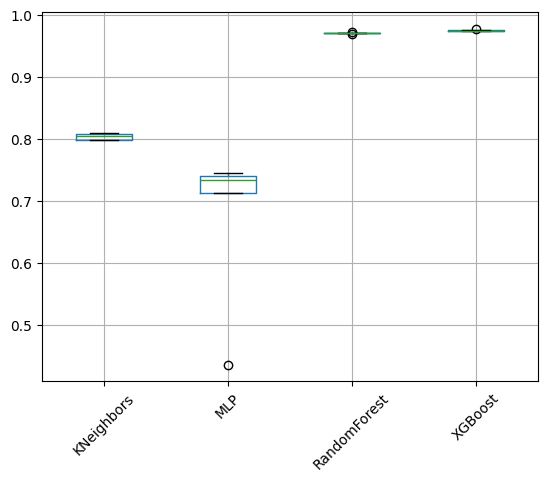

In [ ]:
# Define the list of models that we want to test
models = [
    ('RandomForest', RandomForestClassifier()),
    # ('LogisticRegression', LogisticRegression(max_iter=250)),
    ('KNeighbors', KNeighborsClassifier()),
    ('XGBoost', XGBClassifier()),
    ('MLP', MLPClassifier(max_iter=100))
]

# An empty list to capture the performance of each model
model_comps = []

# Walk through the models and populate our list
for model_name, model in models:
    # Train the model
    model.fit(binary_train_X, binary_train_y)

    # Save the model to a file
    joblib.dump(model, f'{model_name}_model.pkl')

    # Evaluate the model using cross-validation
    accuracies = cross_val_score(model, binary_train_X, binary_train_y, scoring='accuracy')

    # Append the performance results to the list
    for count, accuracy in enumerate(accuracies):
        model_comps.append((model_name, count, accuracy))

# Create a DataFrame to visualize model performance
result_df = pd.DataFrame(model_comps, columns=['model_name', 'count', 'accuracy'])
result_df.pivot(index='count', columns='model_name', values='accuracy').boxplot(rot=45)

In [ ]:
def add_predictions(data_set,predictions,y):
    prediction_series = pd.Series(predictions, index=y.index)

    predicted_vs_actual = data_set.assign(predicted=prediction_series)
    original_data = predicted_vs_actual.assign(actual=y).dropna()
    conf_matrix = confusion_matrix(original_data['actual'],
                                   original_data['predicted'])

    base_errors = original_data[original_data['actual'] != original_data['predicted']]

    non_zeros = base_errors.loc[:,(base_errors != 0).any(axis=0)]

    false_positives = non_zeros.loc[non_zeros.actual==0]
    false_negatives = non_zeros.loc[non_zeros.actual==1]

    prediction_data = {'data': original_data,
                       'confusion_matrix': conf_matrix,
                       'errors': base_errors,
                       'non_zeros': non_zeros,
                       'false_positives': false_positives,
                       'false_negatives': false_negatives}

    return prediction_data

Model:               Random Forest
Accuracy:            0.9710
Precision:           0.9786
Recall:              0.9682
F1-Score:            0.9734
ROC-AUC:             0.9963
Log Loss:            0.0885
Confusion Matrix:
[[21808   573]
 [  859 26160]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.97     22381
 DDos Attack       0.98      0.97      0.97     27019

    accuracy                           0.97     49400
   macro avg       0.97      0.97      0.97     49400
weighted avg       0.97      0.97      0.97     49400



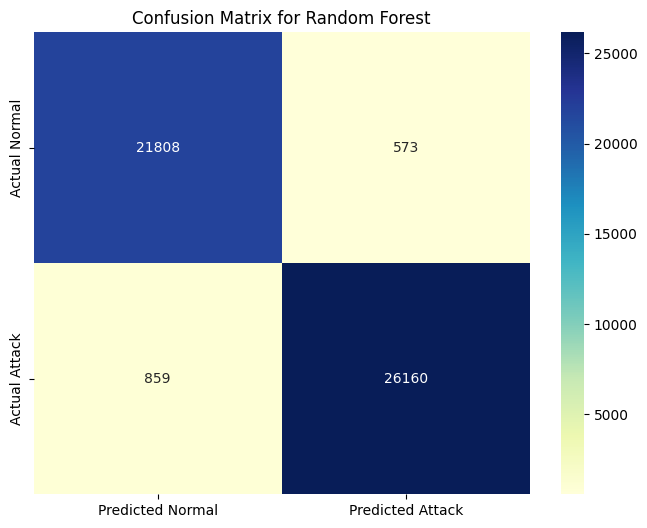

Model:               K-Nearest Neighbors
Accuracy:            0.8043
Precision:           0.8243
Recall:              0.8162
F1-Score:            0.8202
ROC-AUC:             0.9057
Log Loss:            1.0515
Confusion Matrix:
[[17680  4701]
 [ 4965 22054]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.78      0.79      0.79     22381
 DDos Attack       0.82      0.82      0.82     27019

    accuracy                           0.80     49400
   macro avg       0.80      0.80      0.80     49400
weighted avg       0.80      0.80      0.80     49400



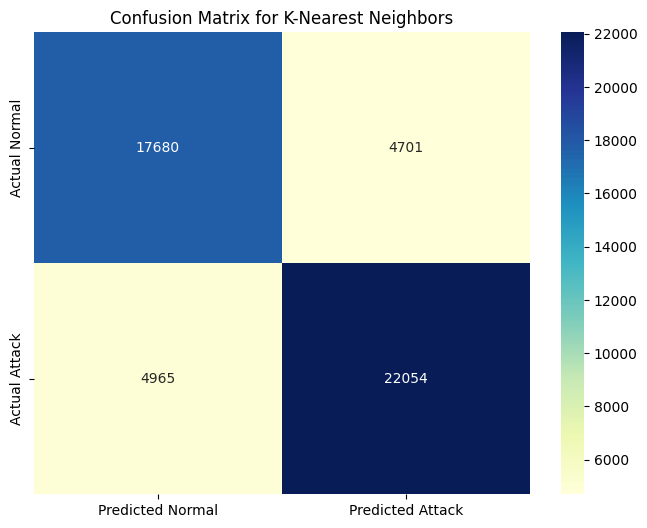

Model:               XGBoost Classifier
Accuracy:            0.9759
Precision:           0.9830
Recall:              0.9728
F1-Score:            0.9779
ROC-AUC:             0.9972
Log Loss:            0.0633
Confusion Matrix:
[[21926   455]
 [  735 26284]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.97     22381
 DDos Attack       0.98      0.97      0.98     27019

    accuracy                           0.98     49400
   macro avg       0.98      0.98      0.98     49400
weighted avg       0.98      0.98      0.98     49400



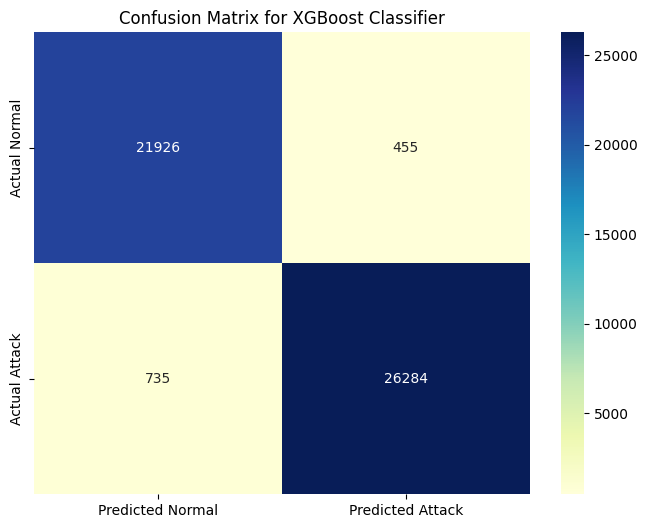

Model:               Neural Network
Accuracy:            0.7647
Precision:           0.8997
Recall:              0.6412
F1-Score:            0.7488
ROC-AUC:             0.7779
Log Loss:            8.4681
Confusion Matrix:
[[20450  1931]
 [ 9695 17324]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.68      0.91      0.78     22381
 DDos Attack       0.90      0.64      0.75     27019

    accuracy                           0.76     49400
   macro avg       0.79      0.78      0.76     49400
weighted avg       0.80      0.76      0.76     49400



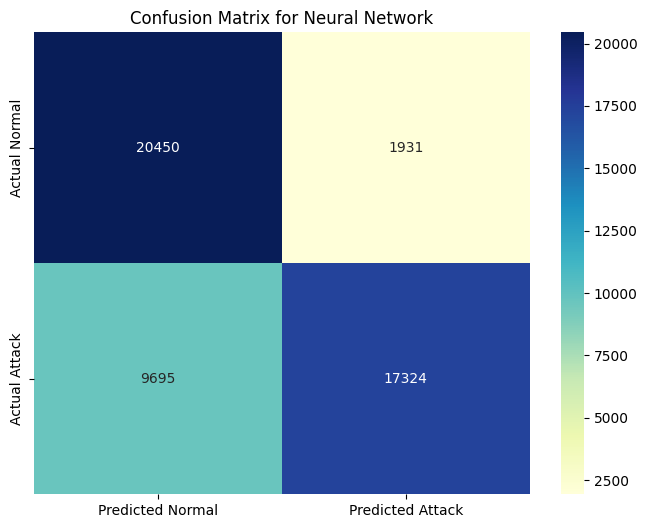

                     Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
Random Forest        0.971012   0.978566  0.968208  0.973359  0.996344   
K-Nearest Neighbors  0.804332   0.824295  0.816240  0.820248  0.905733   
XGBoost Classifier   0.975911   0.982984  0.972797  0.977864  0.997224   
Neural Network       0.764656   0.899714  0.641178  0.748757  0.777870   

                     Log Loss  
Random Forest        0.088524  
K-Nearest Neighbors  1.051468  
XGBoost Classifier   0.063290  
Neural Network       8.468121  


In [ ]:
# Load models
rf_model = joblib.load(r'/content/RandomForest_model.pkl')
# lr_model = joblib.load(r'/kaggle/working/LogisticRegression_model.pkl')
knn_model = joblib.load(r'/content/KNeighbors_model.pkl')
xgb_model = joblib.load(r'/content/XGBoost_model.pkl')
mlp_model = joblib.load(r'/content/MLP_model.pkl')

# Function to evaluate the model and store results in a dictionary
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, results_dict):
    predictions = model.predict(X_val)
    probs = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions, average='binary')
    recall = recall_score(y_val, predictions, average='binary')
    f1 = f1_score(y_val, predictions, average='binary')
    roc_auc = roc_auc_score(y_val, probs) if probs is not None else np.nan  # ROC-AUC requires probability scores
    logloss = log_loss(y_val, probs) if probs is not None else np.nan  # Log loss requires probability scores

    # Store the results in the dictionary
    results_dict[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Log Loss': logloss
    }

    # Confusion Matrix and Classification Report
    conf_matrix = confusion_matrix(y_val, predictions)
    class_report = classification_report(y_val, predictions, target_names=['Normal', 'DDos Attack'])

    # Print results with alignment
    print(f"{'Model:'.ljust(20)} {model_name}")
    print(f"{'Accuracy:'.ljust(20)} {accuracy:.4f}")
    print(f"{'Precision:'.ljust(20)} {precision:.4f}")
    print(f"{'Recall:'.ljust(20)} {recall:.4f}")
    print(f"{'F1-Score:'.ljust(20)} {f1:.4f}")
    print(f"{'ROC-AUC:'.ljust(20)} {roc_auc:.4f}")
    print(f"{'Log Loss:'.ljust(20)} {logloss:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Confusion Matrix Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=['Predicted Normal', 'Predicted Attack'],
                yticklabels=['Actual Normal', 'Actual Attack'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Dictionary to store the results for each model
results = {}

# Evaluate each model
evaluate_model(rf_model, binary_train_X, binary_train_y, binary_val_X, binary_val_y, 'Random Forest', results)
# evaluate_model(lr_model, binary_train_X, binary_train_y, binary_val_X, binary_val_y, 'Logistic Regression', results)
evaluate_model(knn_model, binary_train_X, binary_train_y, binary_val_X, binary_val_y, 'K-Nearest Neighbors', results)
evaluate_model(xgb_model, binary_train_X, binary_train_y, binary_val_X, binary_val_y, 'XGBoost Classifier', results)
evaluate_model(mlp_model, binary_train_X, binary_train_y, binary_val_X, binary_val_y, 'Neural Network', results)

# Convert the results dictionary to a pandas DataFrame
results_df = pd.DataFrame(results).T  # Transpose to have models as rows and metrics as columns

# Save the results to a CSV file
results_df.to_csv('/content/Results/UNSW_results.csv')

# Display the results DataFrame
print(results_df)

In [ ]:
#Multi-Class Classification

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_test = pd.read_csv('/content/UNSW_NB15_testing-set.csv')
df_train = pd.read_csv('/content/UNSW_NB15_training-set.csv')

In [ ]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
257669,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
257670,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
257671,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [ ]:
y = df['attack_cat']

def change_label(df):
    y.replace(['Normal'],'0',inplace=True)
    y.replace(['DoS'],'1',inplace=True)
    y.replace(['Generic'],'2',inplace=True)
    y.replace(['Exploits'],'3',inplace=True)
    y.replace(['Fuzzers'],'4',inplace=True)
    y.replace(['Analysis'],'5',inplace=True)
    y.replace(['Backdoor'],'6',inplace=True)
    y.replace(['Reconnaissance'],'7',inplace=True)
    y.replace(['Shellcode'],'8',inplace=True)
    y.replace(['Worms'],'9',inplace=True)

change_label(y)
y = y.astype(int)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder

In [ ]:
nominal_columns = ['proto','service','state']
df_nominal = df[nominal_columns]
encoder = OneHotEncoder(sparse_output = False)
df_nominal = encoder.fit_transform(df_nominal)

In [ ]:
df_nominal = pd.DataFrame(df_nominal,columns=encoder.get_feature_names_out())
df_nominal

,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,...,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
257669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
257670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
257671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
non_numeric_columns = ['id','proto','service','state','attack_cat','label']
df_numeric = df.drop(non_numeric_columns,axis=1)
scaler = MinMaxScaler()
df_numeric = scaler.fit_transform(df_numeric)
df_numeric = pd.DataFrame(df_numeric,columns=scaler.get_feature_names_out())
df_numeric

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,1.833334e-07,0.000094,0.000000,0.000033,0.000000,0.090909,0.996078,0.000000,0.030121,0.000000,...,0.000000,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0
1,1.333334e-07,0.000094,0.000000,0.000121,0.000000,0.125000,0.996078,0.000000,0.147128,0.000000,...,0.000000,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0
2,8.333335e-08,0.000094,0.000000,0.000073,0.000000,0.200000,0.996078,0.000000,0.142685,0.000000,...,0.000000,0.000000,0.000000,0.031250,0.0,0.0,0.0,0.000000,0.032787,0.0
3,1.000000e-07,0.000094,0.000000,0.000061,0.000000,0.166667,0.996078,0.000000,0.100200,0.000000,...,0.017241,0.017241,0.000000,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0
4,1.666667e-07,0.000094,0.000000,0.000146,0.000000,0.100000,0.996078,0.000000,0.142017,0.000000,...,0.017241,0.017241,0.000000,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,1.500000e-07,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,0.008461,0.000000,...,0.396552,0.396552,0.266667,0.359375,0.0,0.0,0.0,0.389831,0.377049,0.0
257669,8.429368e-03,0.000845,0.000726,0.000042,0.000024,0.000034,0.996078,0.992126,0.000001,0.000219,...,0.000000,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.000000,0.0
257670,1.500000e-07,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,0.008461,0.000000,...,0.034483,0.034483,0.044444,0.187500,0.0,0.0,0.0,0.033898,0.180328,0.0
257671,1.500000e-07,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,0.008461,0.000000,...,0.500000,0.500000,0.288889,0.453125,0.0,0.0,0.0,0.491525,0.475410,0.0


In [ ]:
X = pd.concat([df_nominal,df_numeric],axis=1)
X

,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.031250,0.0,0.0,0.0,0.000000,0.032787,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017241,0.017241,0.000000,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017241,0.017241,0.000000,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.396552,0.396552,0.266667,0.359375,0.0,0.0,0.0,0.389831,0.377049,0.0
257669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.000000,0.0
257670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.034483,0.034483,0.044444,0.187500,0.0,0.0,0.0,0.033898,0.180328,0.0
257671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500000,0.500000,0.288889,0.453125,0.0,0.0,0.0,0.491525,0.475410,0.0


In [ ]:
#data Spliting

In [ ]:
X_train = X[:175341]
X_test = X[175341:]
y_train = y[:175341]
y_test = y[175341:]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
# random forest
model_rf = RandomForestClassifier(n_estimators = 100,
                                  n_jobs=-1,random_state=0,
                                  bootstrap=True,).fit(X_train,y_train)

# pred
y_pred_rf = model_rf.predict(X_test)

In [ ]:
def metric(y_pred):
    accuracy = metrics.accuracy_score(y_pred, y_test)
    recall = metrics.recall_score(y_pred, y_test, average='macro')
    precision = metrics.precision_score(y_pred, y_test, average='macro')
    f1_score = metrics.f1_score(y_pred, y_test, average='macro')
    cm = metrics.confusion_matrix(y_test, y_pred)
    print(f'accuracy: {accuracy}')
    print(f'recall: {recall}')
    print(f'precision: {precision}')
    print(f'f1_score: {f1_score}')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()



In [ ]:
model_mlp = MLPClassifier(hidden_layer_sizes = (80,40,40,),
                          activation='relu',
                          solver='adam',
                          batch_size=1000,
                          verbose=0).fit(X_train,y_train)

y_pred_mlp = model_mlp.predict(X_test)

accuracy: 0.7948428314628577
recall: 0.716433952607832
precision: 0.4916359621574425
f1_score: 0.4875561874079411


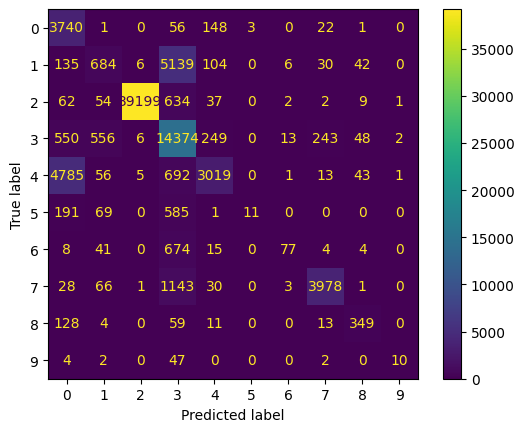

accuracy: 0.7899965991352087
recall: 0.6503783875807237
precision: 0.4739663681033046
f1_score: 0.46484275657813


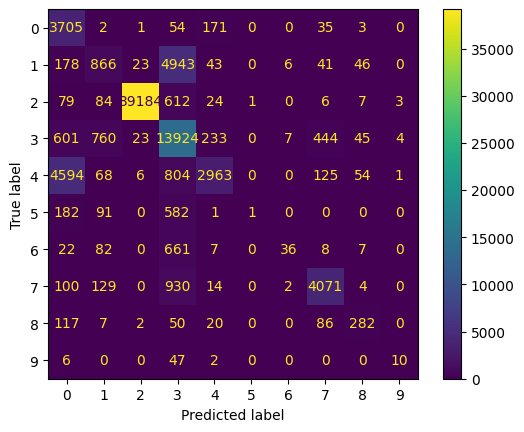

In [ ]:
metric(y_pred_rf)
metric(y_pred_mlp)